## Human Segmentaion by UNet
* make sure to install the following packages in addition to pytorch_lightning package
`!pip install segmentation-models-pytorch`                                                  
`!pip install -U git+https://github.com/albumentations-team/albumentations`                                  
`pip install --upgrade opencv-contrib-python`
* use datasets in "../data/Human-Segmentation-Dataset-master"

### Data Preparation

#### Load data and check training dataset

In [1]:
import os
import pandas as pd
ground_truth_num = len(os.listdir("../data/Human-Segmentation-Dataset-master/Ground_Truth"))
training_img_num = len(os.listdir("../data/Human-Segmentation-Dataset-master/Training_Images"))
print(f'{ground_truth_num}, {training_img_num}')
df = pd.read_csv("../data/Human-Segmentation-Dataset-master/train.csv")
df

291, 291


,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
...,...,...
285,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
286,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
287,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
288,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [2]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import albumentations as A
import segmentation_models_pytorch
import torchmetrics

In [3]:
CSV_FILE = '../data/Human-Segmentation-Dataset-master/train.csv'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [4]:
df = pd.read_csv(CSV_FILE)
df.head

<bound method NDFrame.head of                                                  masks  \
0    Human-Segmentation-Dataset-master/Ground_Truth...   
1    Human-Segmentation-Dataset-master/Ground_Truth...   
2    Human-Segmentation-Dataset-master/Ground_Truth...   
3    Human-Segmentation-Dataset-master/Ground_Truth...   
4    Human-Segmentation-Dataset-master/Ground_Truth...   
..                                                 ...   
285  Human-Segmentation-Dataset-master/Ground_Truth...   
286  Human-Segmentation-Dataset-master/Ground_Truth...   
287  Human-Segmentation-Dataset-master/Ground_Truth...   
288  Human-Segmentation-Dataset-master/Ground_Truth...   
289  Human-Segmentation-Dataset-master/Ground_Truth...   

                                                images  
0    Human-Segmentation-Dataset-master/Training_Ima...  
1    Human-Segmentation-Dataset-master/Training_Ima...  
2    Human-Segmentation-Dataset-master/Training_Ima...  
3    Human-Segmentation-Dataset-master/Traini

In [8]:
from pathlib import Path

DATA_DIR = Path("../data")
row = df.iloc[0]
image_path = DATA_DIR / row.images
mask_path = DATA_DIR / row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

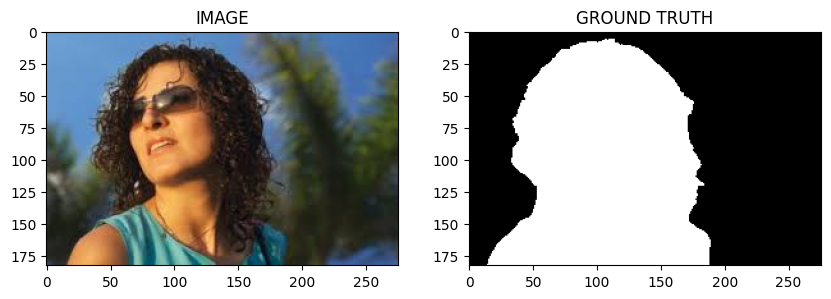

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')
# ax2.imshow(mask)

#### Data Augmentation

In [10]:
# apply to training dataset
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ], is_check_shapes=False)

# apply to inference
def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
  ], is_check_shapes=False)

#### Build Training Dataset

In [12]:
from torch.utils.data import Dataset
import pytorch_lightning as pl
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torch.utils.data import DataLoader
import torchmetrics
from torchmetrics.segmentation import DiceScore

dice = DiceScore(num_classes=2, average="micro")  # ✅ Correct

In [18]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  # return image, mask pair according to index
  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = DATA_DIR / row.images
    mask_path = DATA_DIR / row.masks
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # mask at grayscale only has two dimension, (height, width)
    # we will add a channel dimension to mask image to have (h, w, c)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      # return images and masks in dictionary format
      data = self.augmentations(image = image, mask = mask)

      # extract image and mask from the dictionary
      image = data['image']
      mask = data['mask']

      # reformat the dimensions to pytorch format (c, h, w)
      image = np.transpose(image, (2, 0, 1)).astype(np.float32)
      mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

      # convert np arrays to tensors
      image = torch.Tensor(image) / 255.0
      mask = torch.round(torch.Tensor(mask) / 255.0)

      return image, mask

In [24]:
import pytorch_lightning as pl
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torch.utils.data import DataLoader

class ImageDataModule(pl.LightningDataModule):
  prepare_data_per_node = True
  allow_zero_length_dataloader_with_multiple_devices = True
  def __init__(self, data_df, batch_size, learning_rate=0.001):
    self.df = data_df
    self.batch_size = batch_size
    
  def prepare_data(self) -> None:
    train_df, self.test_df = train_test_split(self.df, test_size = 0.2, random_state=42)
    self.train_df, self.valid_df = train_test_split(train_df, test_size=0.15, random_state=42)

  def setup(self, stage: str) -> None:
    if stage == "fit" or stage is None:
      self.train_dataset = SegmentationDataset(self.train_df, get_train_augs())
      self.valid_dataset = SegmentationDataset(self.valid_df, get_train_augs())
    elif stage == "test" or stage is None:
      self.test_dataset = SegmentationDataset(self.test_df, get_valid_augs())

  def log_register(self) -> None:
    params = {'learning_rate': 0.001, 'batch_size': 32}
    metrics ={'train_loss': 0.0, 'val_loss': 0.0, 'test_loss': 0.0, 'val_dice': 0.0}
    
  def _log_hyperparams(self, params, metrics=None):        
        self.logger.log_hyperparams(params)

  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size=self.batch_size)

  def val_dataloader(self):
    return DataLoader(self.valid_dataset, batch_size=self.batch_size)

  def test_dataloader(self):
    return DataLoader(self.test_dataset, batch_size=self.batch_size)

class SMPClass(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.dice_loss = DiceLoss(mode='binary')
    self.dice = DiceScore(num_classes=2, average="micro")

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):
    logits = self.arc(images)
    return logits

  def training_step(self, batch, batch_idx):
    images, masks = batch
    logits = self(images)
    loss1 = DiceLoss(mode='binary')(logits, masks)
    loss2 = nn.BCEWithLogitsLoss()(logits, masks)
    loss = loss1 + loss2
    self.log('train_loss', loss)
    return loss

  def validation_step(self, batch, batch_idx):
        images, masks = batch
        logits = self(images)
        loss1 = DiceLoss(mode='binary')(logits, masks)
        loss2 = nn.BCEWithLogitsLoss()(logits, masks)
        loss = loss1 + loss2
        self.log('val_loss', loss)
        image_preds = (logits.sigmoid() > 0.5).float()
        dice_score = self.dice(image_preds, masks.long())
        self.log('val_dice', dice_score)
        return loss

  def test_step(self, batch, batch_idx):
      images, masks = batch
      logits = self(images)
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      loss = loss1 + loss2
      self.log('test_loss', loss)
      return loss

  def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
      return optimizer

In [25]:
from pytorch_lightning.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
        save_top_k=1,
        verbose=True,
        monitor='val_dice',
        mode='max'
    ) 

# define DataModule and Module class objects
dm = ImageDataModule(df, 32)
model = SMPClass()

trainer = pl.Trainer(max_epochs=15, accelerator="gpu", 
                     enable_checkpointing=True,callbacks=[checkpoint_callback])
trainer.fit(model, dm)
trainer.test(datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | dice_loss | DiceLoss  | 0      | train
1 | dice      | DiceScore | 0      | train
2 | arc       | Unet      | 6.3 M  | train
------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.006    Total estimated model params size (MB)
412       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Epoch 0, global step 7: 'val_dice' reached 0.51921 (best 0.51921), saving model to 'C:\\Users\\huang\\Documents\\yuanML\\Computer_Vision\\segmentation_analysis\\lightning_logs\\version_6\\checkpoints\\epoch=0-step=7.ckpt' as top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 1, global step 14: 'val_dice' reached 0.80551 (best 0.80551), saving model to 'C:\\Users\\huang\\Documents\\yuanML\\Computer_Vision\\segmentation_analysis\\lightning_logs\\version_6\\checkpoints\\epoch=1-step=14.ckpt' as top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 2, global step 21: 'val_dice' reached 0.84148 (best 0.84148), saving model to 'C:\\Users\\huang\\Documents\\yuanML\\Computer_Vision\\segmentation_analysis\\lightning_logs\\version_6\\checkpoints\\epoch=2-step=21.ckpt' as top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 3, global step 28: 'val_dice' reached 0.87266 (best 0.87266), saving model to 'C:\\Users\\huang\\Documents\\yuanML\\Computer_Vision\\segmentation_analysis\\lightning_logs\\version_6\\checkpoints\\epoch=3-step=28.ckpt' as top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 4, global step 35: 'val_dice' reached 0.91321 (best 0.91321), saving model to 'C:\\Users\\huang\\Documents\\yuanML\\Computer_Vision\\segmentation_analysis\\lightning_logs\\version_6\\checkpoints\\epoch=4-step=35.ckpt' as top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 5, global step 42: 'val_dice' reached 0.91545 (best 0.91545), saving model to 'C:\\Users\\huang\\Documents\\yuanML\\Computer_Vision\\segmentation_analysis\\lightning_logs\\version_6\\checkpoints\\epoch=5-step=42.ckpt' as top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 6, global step 49: 'val_dice' was not in top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 7, global step 56: 'val_dice' reached 0.92729 (best 0.92729), saving model to 'C:\\Users\\huang\\Documents\\yuanML\\Computer_Vision\\segmentation_analysis\\lightning_logs\\version_6\\checkpoints\\epoch=7-step=56.ckpt' as top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 8, global step 63: 'val_dice' was not in top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 9, global step 70: 'val_dice' was not in top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 10, global step 77: 'val_dice' reached 0.92746 (best 0.92746), saving model to 'C:\\Users\\huang\\Documents\\yuanML\\Computer_Vision\\segmentation_analysis\\lightning_logs\\version_6\\checkpoints\\epoch=10-step=77.ckpt' as top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 11, global step 84: 'val_dice' was not in top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 12, global step 91: 'val_dice' was not in top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 13, global step 98: 'val_dice' reached 0.93202 (best 0.93202), saving model to 'C:\\Users\\huang\\Documents\\yuanML\\Computer_Vision\\segmentation_analysis\\lightning_logs\\version_6\\checkpoints\\epoch=13-step=98.ckpt' as top 1


Validation: |                                                                                    | 0/? [00:00<…

Epoch 14, global step 105: 'val_dice' reached 0.93333 (best 0.93333), saving model to 'C:\\Users\\huang\\Documents\\yuanML\\Computer_Vision\\segmentation_analysis\\lightning_logs\\version_6\\checkpoints\\epoch=14-step=105.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=15` reached.
C:\Users\huang\anaconda3\envs\gpu\lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at C:\Users\huang\Documents\yuanML\Computer_Vision\segmentation_analysis\lightning_logs\version_6\checkpoints\epoch=14-step=105.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at C:\Users\huang\Documents\yuanML\Computer_Vision\segmentation_an

Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.1958400458097458     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.1958400458097458}]

In [27]:
best_model_path = checkpoint_callback.best_model_path
best_val_loss = checkpoint_callback.best_model_score
print(f"best_model_path: {best_model_path}, best_val_loss: {best_val_loss}")

best_model_path: C:\Users\huang\Documents\yuanML\Computer_Vision\segmentation_analysis\lightning_logs\version_6\checkpoints\epoch=14-step=105.ckpt, best_val_loss: 0.9333322644233704


In [28]:
best_model = SMPClass.load_from_checkpoint(best_model_path)
type(best_model)

__main__.SMPClass

In [61]:
idx =2
vd = SegmentationDataset(df[-10:], get_valid_augs())

image, mask = vd[idx]
image = image.to(DEVICE)

logits_mask = best_model(image.unsqueeze(0))
image = image.detach().cpu()

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0
pred_mask = pred_mask.detach().cpu().squeeze(0)
print(f"pred_mask.shape: {pred_mask.shape}, mask.shape: {mask.shape}")

pred_mask.shape: torch.Size([1, 320, 320]), mask.shape: torch.Size([1, 320, 320])


In [62]:
import matplotlib.pyplot as plt 
import numpy as np 
import torch


def show_image(image,mask,pred_image):
    
    if pred_image.size == 0:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
    else :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')
        

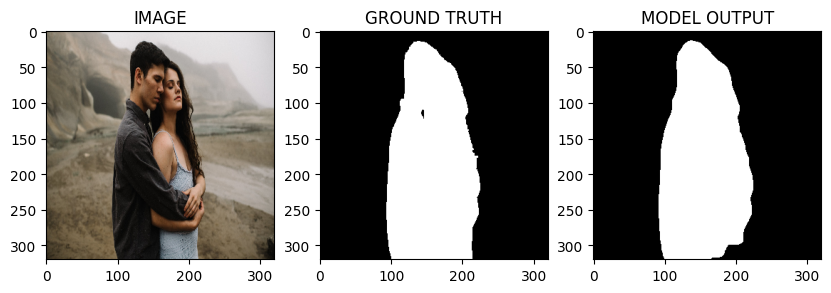

In [63]:
show_image(image, mask, pred_mask)